# Package

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Environment config

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = raw_to_dict()

  0%|          | 0/117273 [00:00<?, ?it/s]


>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/msimut
>> Total running 75039

>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/mss


100%|██████████| 117273/117273 [00:00<00:00, 992605.31it/s]


>> Total running 117273

>> Splitting the dataset


Total amount of train msimut/mss: 52 and 236


Total amount of train msimut/mss: 13 and 59

>> Passing the criteria

>> From dictionary to data instance


>> Sumary between two classes:
msimut 65137
mss 86718


>> Sumary between two classes:
msimut 9902
mss 30555

>> Done!


In [6]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(2373, 633)

torch.Size([64, 3, 224, 224]) torch.Size([64])


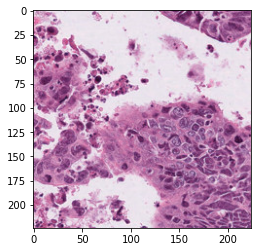

In [18]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# SkNet-DualAttention model

In [7]:
from trainer.sknet_trainer import SKNetTrainer

In [8]:
sknet_trainer = SKNetTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = sknet_trainer.get_max_epochs()

In [9]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "sknet", "full")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/full'

In [10]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "sknet")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [12]:
# from models.sknet import sknet18_32x4d

In [13]:
# model = sknet18_32x4d(2)
# model = model.to(device)
# torch.cuda.empty_cache()
# model(images.to(device))

# Learning rate finder

In [21]:
lr_finder = trainer.lr_find(sknet_trainer)

INFO:lightning:
    | Name                                                                    | Type              | Params
----------------------------------------------------------------------------------------------------------
0   | criterion                                                               | BCEWithLogitsLoss | 0     
1   | model                                                                   | SKNet             | 16 M  
2   | model.stem_head                                                         | Sequential        | 9 K   
3   | model.stem_head.0                                                       | Conv2d            | 9 K   
4   | model.stem_head.1                                                       | BatchNorm2d       | 128   
5   | model.stem_head.2                                                       | ReLU              | 0     
6   | model.stem_head.3                                                       | MaxPool2d         | 0     
7   | model.layer_1  

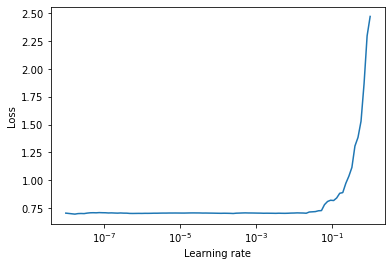

In [22]:
fig = lr_finder.plot(suggest = True)

In [11]:
sknet_trainer.base_lr = 1e-4
sknet_trainer.max_lr = 1e-4
sknet_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 4e-06
    lr: 4.000000000000002e-06
    max_lr: 0.0001
    max_momentum: 0.95
    min_lr: 3.9999999999999996e-10
    momentum: 0.95
    nesterov: True
    weight_decay: 0.0001
)

# Start to train the model

In [12]:
trainer.fit(sknet_trainer)

INFO:lightning:
    | Name                                                                    | Type              | Params
----------------------------------------------------------------------------------------------------------
0   | criterion                                                               | BCEWithLogitsLoss | 0     
1   | model                                                                   | SKNet             | 16 M  
2   | model.stem_head                                                         | Sequential        | 9 K   
3   | model.stem_head.0                                                       | Conv2d            | 9 K   
4   | model.stem_head.1                                                       | BatchNorm2d       | 128   
5   | model.stem_head.2                                                       | ReLU              | 0     
6   | model.stem_head.3                                                       | MaxPool2d         | 0     
7   | model.layer_1  

INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_0.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_2.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_3.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_4.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_5.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_6.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_7.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_8.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_9.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_10.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_11.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_12.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_13.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_14.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_15.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_16.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_17.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_18.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_19.ckpt


INFO:lightning:
Epoch 00020: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_20.ckpt


INFO:lightning:
Epoch 00021: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_21.ckpt


INFO:lightning:
Epoch 00022: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_22.ckpt


INFO:lightning:
Epoch 00023: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_23.ckpt


INFO:lightning:
Epoch 00024: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_24.ckpt


INFO:lightning:
Epoch 00025: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_25.ckpt


INFO:lightning:
Epoch 00026: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_26.ckpt


INFO:lightning:
Epoch 00027: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_27.ckpt


INFO:lightning:
Epoch 00028: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_28.ckpt


INFO:lightning:
Epoch 00029: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknet/_ckpt_epoch_29.ckpt


1

# Evaluate the model

## Run test set

In [7]:
from evaluate.evaluator import Evaluator
from trainer.sknet_trainer import SKNetTrainer

checkpoint_path = ["checkpoint/eval/sknet/small/epoch={}.ckpt".format(x) for x in range(1, 20)]
evaluator = Evaluator(SKNetTrainer, "SKNet", checkpoint_path, trainloader, valloader, valset, "logs/eval/sknet/version2/")

In [9]:
evaluator.run_validation()

>> Evaluate checkpoint/eval/sknet/full/epoch=1.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:52<00:00,  1.34it/s]


{'accuracy_score/patient-level': 0.786096256684492,
 'accuracy_score/picture-level': 0.6187605763550251,
 'auc_score/patient-level': 0.7072279892349096,
 'auc_score/picture-level': 0.5959163358104637,
 'f1_score/patient-level': 0.8773006134969324,
 'f1_score/picture-level': 0.7240774560106676,
 'precision_score/patient-level': 0.8265895953757225,
 'precision_score/picture-level': 0.6658358767943062,
 'recall_score/patient-level': 0.934640522875817,
 'recall_score/picture-level': 0.793484648739656}
>> Evaluate checkpoint/eval/sknet/full/epoch=2.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.5508021390374331,
 'accuracy_score/picture-level': 0.6179695400975278,
 'auc_score/patient-level': 0.8412149173394848,
 'auc_score/picture-level': 0.7783698674614477,
 'f1_score/patient-level': 0.625,
 'f1_score/picture-level': 0.6149778490912577,
 'precision_score/patient-level': 0.9859154929577465,
 'precision_score/picture-level': 0.8432501245364477,
 'recall_score/patient-level': 0.45751633986928103,
 'recall_score/picture-level': 0.4839657554916692}
>> Evaluate checkpoint/eval/sknet/full/epoch=3.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:01<00:00,  1.30it/s]


{'accuracy_score/patient-level': 0.7807486631016043,
 'accuracy_score/picture-level': 0.6981445693858955,
 'auc_score/patient-level': 0.9038831218762015,
 'auc_score/picture-level': 0.7856262520001094,
 'f1_score/patient-level': 0.8487084870848708,
 'f1_score/picture-level': 0.7342044472658662,
 'precision_score/patient-level': 0.9745762711864406,
 'precision_score/picture-level': 0.8251451673636021,
 'recall_score/patient-level': 0.7516339869281046,
 'recall_score/picture-level': 0.66131927127178}
>> Evaluate checkpoint/eval/sknet/full/epoch=4.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:59<00:00,  1.30it/s]


{'accuracy_score/patient-level': 0.40641711229946526,
 'accuracy_score/picture-level': 0.5957304068329512,
 'auc_score/patient-level': 0.9457900807381776,
 'auc_score/picture-level': 0.8544534295861349,
 'f1_score/patient-level': 0.43076923076923085,
 'f1_score/picture-level': 0.5461351679481992,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9343770435050198,
 'recall_score/patient-level': 0.27450980392156865,
 'recall_score/picture-level': 0.38582251941739865}
>> Evaluate checkpoint/eval/sknet/full/epoch=5.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:06<00:00,  1.27it/s]


{'accuracy_score/patient-level': 0.8235294117647058,
 'accuracy_score/picture-level': 0.6986752645966215,
 'auc_score/patient-level': 0.962322183775471,
 'auc_score/picture-level': 0.80987674010552,
 'f1_score/patient-level': 0.8791208791208792,
 'f1_score/picture-level': 0.7229031040229832,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.8600411901318961,
 'recall_score/patient-level': 0.7843137254901961,
 'recall_score/picture-level': 0.6234851252402357}
>> Evaluate checkpoint/eval/sknet/full/epoch=6.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:58<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.6310160427807486,
 'accuracy_score/picture-level': 0.6153761427469986,
 'auc_score/patient-level': 0.8154555940023067,
 'auc_score/picture-level': 0.7033232989216547,
 'f1_score/patient-level': 0.7206477732793523,
 'f1_score/picture-level': 0.6391680913821933,
 'precision_score/patient-level': 0.9468085106382979,
 'precision_score/picture-level': 0.7821818599839062,
 'recall_score/patient-level': 0.5816993464052288,
 'recall_score/picture-level': 0.540367540780508}
>> Evaluate checkpoint/eval/sknet/full/epoch=7.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:56<00:00,  1.32it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9721935735813916,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9952651316916051,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9780291941928082,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9743521029068668,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9817341444432091}
>> Evaluate checkpoint/eval/sknet/full/epoch=8.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:49<00:00,  1.35it/s]


{'accuracy_score/patient-level': 0.8181818181818182,
 'accuracy_score/picture-level': 0.6628082788452874,
 'auc_score/patient-level': 0.9171472510572856,
 'auc_score/picture-level': 0.6958820559981433,
 'f1_score/patient-level': 0.9,
 'f1_score/picture-level': 0.7831127427301711,
 'precision_score/patient-level': 0.8181818181818182,
 'precision_score/picture-level': 0.658624574783871,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9656284248479169}
>> Evaluate checkpoint/eval/sknet/full/epoch=9.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 0.9679144385026738,
 'accuracy_score/picture-level': 0.8711311818482211,
 'auc_score/patient-level': 0.9969242599000384,
 'auc_score/picture-level': 0.9411279983534331,
 'f1_score/patient-level': 0.9805194805194806,
 'f1_score/picture-level': 0.8998724092861144,
 'precision_score/patient-level': 0.9741935483870968,
 'precision_score/picture-level': 0.8819098159415649,
 'recall_score/patient-level': 0.9869281045751634,
 'recall_score/picture-level': 0.9185819342746867}
>> Evaluate checkpoint/eval/sknet/full/epoch=10.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9300583764731799,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9896445405510879,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9421967709634974,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9835181921840986,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9042075001191251}
>> Evaluate checkpoint/eval/sknet/full/epoch=11.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:47<00:00,  1.36it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.995153651283181,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9996207895812987,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9961516442974365,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9973411453772548,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.994964977207389}
>> Evaluate checkpoint/eval/sknet/full/epoch=12.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 0.8877005347593583,
 'accuracy_score/picture-level': 0.7552293504490883,
 'auc_score/patient-level': 0.9279123414071512,
 'auc_score/picture-level': 0.8205923097144121,
 'f1_score/patient-level': 0.9315960912052117,
 'f1_score/picture-level': 0.8055831709547858,
 'precision_score/patient-level': 0.9285714285714286,
 'precision_score/picture-level': 0.806757359500446,
 'recall_score/patient-level': 0.934640522875817,
 'recall_score/picture-level': 0.8044123953684144}
>> Evaluate checkpoint/eval/sknet/full/epoch=13.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 0.8877005347593583,
 'accuracy_score/picture-level': 0.7791907398692287,
 'auc_score/patient-level': 0.9988465974625144,
 'auc_score/picture-level': 0.9037540674088196,
 'f1_score/patient-level': 0.9357798165137614,
 'f1_score/picture-level': 0.8494517948087768,
 'precision_score/patient-level': 0.8793103448275862,
 'precision_score/picture-level': 0.7448963708856667,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.988151018917073}
>> Evaluate checkpoint/eval/sknet/full/epoch=14.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9591064294225435,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9980290859344848,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.966591407349236,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9965421270135785,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9383884750393113}
>> Evaluate checkpoint/eval/sknet/full/epoch=15.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.37it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9991989506253192,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9998867929208305,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9993647163458484,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9992853626387588,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9994440826569673}
>> Evaluate checkpoint/eval/sknet/full/epoch=16.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.37it/s]


{'accuracy_score/patient-level': 0.9679144385026738,
 'accuracy_score/picture-level': 0.8467993070922909,
 'auc_score/patient-level': 0.9978854286812764,
 'auc_score/picture-level': 0.9166904778534835,
 'f1_score/patient-level': 0.9807692307692307,
 'f1_score/picture-level': 0.8803996060222316,
 'precision_score/patient-level': 0.9622641509433962,
 'precision_score/picture-level': 0.8667939107546908,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.8944392382344065}
>> Evaluate checkpoint/eval/sknet/full/epoch=17.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 0.8609625668449198,
 'accuracy_score/picture-level': 0.7824450029538695,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9740251833288968,
 'f1_score/patient-level': 0.9071428571428571,
 'f1_score/picture-level': 0.7927623734989175,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9922401031469367,
 'recall_score/patient-level': 0.8300653594771242,
 'recall_score/picture-level': 0.6600644864117918}
>> Evaluate checkpoint/eval/sknet/full/epoch=18.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.36it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.982577176100692,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9989580834794676,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9863168821364537,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9767463593178102,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9960768118934544}
>> Evaluate checkpoint/eval/sknet/full/epoch=19.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:46<00:00,  1.37it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9993391342658883,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9997435765899417,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9994755828181863,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9999841004849352,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9989675820772249}


## Run on noise set

In [9]:
evaluator.run_test_set()

  0%|          | 0/43 [00:00<?, ?it/s]



>> Evaluate speckle noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/speckle
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/speckle.csv


>> Evaluate pepper noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/pepper
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/pepper.csv


>> Evaluate salt noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/salt
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/salt.csv


>> Evaluate poisson noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/poisson
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/poisson.csv


>> Evaluate gaussian noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/gaussian
Transform to dataset and loader
Start evaluating...


100%|██████████| 43/43 [00:13<00:00,  3.24it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/gaussian.csv


## Calibrating graph

In [ ]:
evaluator.calibrater.n_bins = 30
evaluator.calibrated_graph("verions1")

In [ ]:
evaluator.calibrater.n_bins = 5
evaluator.calibrated_graph("verions2")

In [ ]:
evaluator.calibrater.n_bins = 15
evaluator.calibrated_graph("verions3")